In [4]:
import os
import numpy as np
import pandas as pd
#import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.utils import resample
from sklearn.metrics import r2_score, ndcg_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from scipy.stats import spearmanr

import sys
sys.path.append('..')
from src.Datasets import *
#from src.loss import *
import torch

# def sigmoid(x):
#     sig = 1 / (1 + np.exp(-x))
#     return sig
ALL_AAS = ("A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y", "X", "B", "Z", "-", '.')

def hammingdistance(seq1, seq2):
    return sum(s1 != s2 for s1, s2 in zip(seq1, seq2))

In [5]:
font = {'family' : 'arial',
        'size'   : 16}
mpl.rc('font', **font)
mpl.rc('lines', linewidth=2)
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2

In [37]:
file_name = 'GAE_edge'
embeddings = np.load('/scratch/ml/jyang4/ProtGraphR/saved/{}/embeddings.npy'.format(file_name))
fitnessdf = pd.read_csv('fitness.csv')

# #MSAreconstructions = np.load('/home/jyang4/ProtTP/saved/{}/MSAreconstructions.npy'.format(file_name))
# #reconstructions = np.load('/home/jyang4/ProtTP/saved/{}/reconstructions.npy'.format(file_name))

# FILEPATH = '/home/jyang4/ProtTP/data/PABP_AllPreds.csv'
# dataframe = pd.read_csv(FILEPATH)
# dataframe['reconst'] = pd.read_csv('/home/jyang4/ProtTP/saved/{}/reconstructions.csv'.format(file_name)).iloc[:,1]

# dataset = PABPDataset(dataframe=dataframe, encoding='one-hot', attribute_names=['EVMutation','ESM_ensemble']) #'ESM_ensemble''EVMutation'
# MSAembeddings = np.load('/home/jyang4/ProtTP/saved/{}/MSAembeddings.npy'.format(file_name))
# MSAdf = pd.read_csv('/home/jyang4/ProtTP/data/PABP_MSA.csv')
# MSAdf['reconst'] = pd.read_csv('/home/jyang4/ProtTP/saved/{}/MSAreconstructions.csv'.format(file_name)).iloc[:,1]
# MSAdf['wthamming'] = MSAdf.apply(lambda x: hammingdistance(x["seq"][8:-6], MSAdf["seq"][0][8:-6]), axis = 1)

In [36]:
# fitnessdf = pd.read_csv('fitness.csv')
# otherdf = pd.read_csv('fitness_esm_order.csv')[['Combo', 'num_muts']]
# # zsdf = pd.read_csv('/scratch/ml/jyang4/ProtGraphR/data/GB1_AllPredictions.csv')
# # zsdf = zsdf[['Combo', 'EvMutation', 'Triad-FixedBb-dG']]
# # zsdf
# merged = fitnessdf.merge(otherdf, how='left', left_on='Combo', right_on='Combo')
# merged = merged.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis = 1)
# merged
# merged.to_csv('fitness.csv')

In [70]:
# FILEPATH = '/home/jyang4/ProtTP/data/GB1_AllPreds.csv'
# dataframe = pd.read_csv(FILEPATH)
# dataset = GB1Dataset(dataframe=dataframe, encoding='one-hot', attribute_names=["Triad-FixedBb-dG"])

In [11]:
# plt.plot(transformed[len(embeddings):,0], transformed[len(embeddings):,1], '.')
# plt.plot(transformed[:len(embeddings),0], transformed[:len(embeddings),1], '.')
# plt.plot(transformed[len(embeddings),0], transformed[len(embeddings)
# ,1], 'o', markersize = 4)

In [14]:
# plt.plot(transformed[len(embeddings):,0], transformed[len(embeddings):,1], '.')
# plt.plot(transformed[:len(embeddings),0], transformed[:len(embeddings),1], '.')

# #look at where the WT sequence is

# #first one in the MSA embeddings
# plt.plot(transformed[len(embeddings),0], transformed[len(embeddings),1], 'o', markersize = 10)
# #last one in the embeddings
# #plt.plot(transformed[len(embeddings)-1,0], transformed[len(embeddings)-1,1], '.', markersize = 20)
# plt.xlim(0.4, 0.6)
# plt.ylim(0.2, 0.4)

In [38]:
pca = PCA(n_components=2)
transformed = pca.fit_transform(embeddings)
print(pca.explained_variance_ratio_)
fitnessdf[['PCA 1', 'PCA 2']] = transformed

#plot the high fitness values last
fitnessdf["Triad-FixedBb-dG"] = fitnessdf["Triad-FixedBb-dG"].rank()
fitnessdf['EvMutation'] = fitnessdf['EvMutation'].rank()
fitnessdf['rank_fitness'] = fitnessdf['fit'].rank()
fitnessdf = fitnessdf.sort_values('rank_fitness')#'Fitness'

[0.02565313 0.02526094]


In [40]:
fitnessdf

,Unnamed: 0,muts,fit,Combo,EvMutation,Triad-FixedBb-dG,num_muts,PCA 1,PCA 2,rank_fitness
23217,23217,V39H:D40E:G41D:V54K,0.000000,HEDK,110627.5,75026.0,4,1.028084,-0.297831,14739.0
122088,122088,V39G:D40S:G41Q:V54I,0.000000,GSQI,50710.5,70621.0,4,-0.298699,-0.205154,14739.0
57442,57442,V39P:D40K:G41T:V54N,0.000000,PKTN,20888.5,38913.0,4,-0.512917,0.846380,14739.0
24462,24462,V39D:D40W:G41Y:V54K,0.000000,DWYK,26158.0,46167.0,4,0.517237,-0.394313,14739.0
122094,122094,V39T:D40A:G41D:V54W,0.000000,TADW,54742.0,130807.0,4,-1.098198,0.004368,14739.0
...,...,...,...,...,...,...,...,...,...,...
9458,9458,V39F:D40W:G41L:V54G,7.312656,FWLG,130654.0,88837.0,4,-0.568402,0.257966,149357.0
31188,31188,V39F:D40W:G41C:V54A,7.554663,FWCA,105757.0,126037.0,4,-0.430027,0.731524,149358.0
60410,60410,V39A:D40N:G41C:V54A,7.556869,ANCA,133885.5,139742.0,4,-0.354584,0.356068,149359.0
32628,32628,V39F:D40Y:G41A:V54A,8.045152,FYAA,137657.0,142670.0,4,-0.627387,0.273472,149360.0


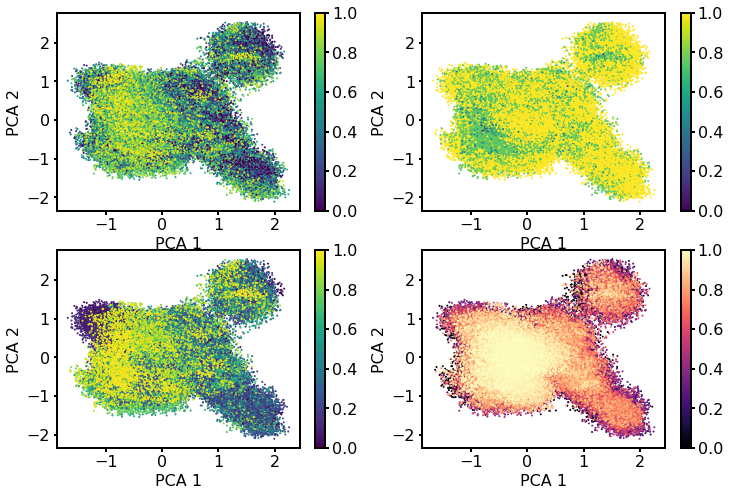

In [39]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

for i, attribute in enumerate(["EvMutation", "num_muts", "Triad-FixedBb-dG", 'rank_fitness']):
#for i, attribute in enumerate(['Triad-FixedBb-dG', 'EvMutation', 'esm_msa1_t12_100M_UR50S-Naive-ColumnUnmasked', 'Fitness']):
    ax = axs.reshape(-1)[i]
    if i == 3:
        color = 'magma'
    else:
        color = 'viridis'
    
    #ax.scatter(x=transformed[:,0], y=transformed[:,1])
    ax.scatter(data=fitnessdf, x='PCA 1', y='PCA 2', s=1, c=attribute, cmap=color)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=color), ax=ax)
    ax.set_xlabel('PCA 1')
    ax.set_ylabel('PCA 2')
    #cbar.set_label(attribute, rotation=270)

plt.savefig('figures/{}.jpg'.format(file_name), dpi = 500)